In [1]:
import torch
from torch import nn
import copy
from tqdm import tqdm
from lib.ekyn import load_ekyn_pt_robust
import torch
from torch.utils.data import Dataset
from lib.ekyn import get_dataloaders,get_ekyn_ids
from torch.utils.data import DataLoader

class Dumbledore(nn.Module):
    def __init__(self,encoder_experiment_name,sequence_length,hidden_size=16,dropout=None) -> None:
        super().__init__()
        self.frozen = True
        self.sequence_length = sequence_length
        self.encoder = self.get_encoder(encoder_experiment_name)
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size, num_layers=3, batch_first=True, dropout=dropout)
        self.classifier = nn.Linear(in_features=hidden_size,out_features=3)
    def forward(self,x):
        x = x.flatten(0,1)
        x = self.encoder(x)
        x = x.reshape(-1,self.sequence_length,3)
        output, (hn, cn) = self.lstm(x)
        x = nn.functional.relu(output[:,-1])
        x = self.classifier(x)
        return x
    def get_encoder(self,encoder_experiment_name):
        state = torch.load(f'experiments/{encoder_experiment_name}/state.pt',map_location='cpu')
        encoder = copy.deepcopy(state['model'])
        encoder.load_state_dict(state['best_model_wts'])
        if self.frozen:
            print("Model is freezing encoder")
            for p in encoder.parameters():
                p.requires_grad = False
        return encoder
class SequencedDatasetv2(Dataset):
    def __init__(self, id, condition, sequence_length, stride=1):
        self.sequence_length = sequence_length
        X, y = load_ekyn_pt_robust(id=id, condition=condition, downsampled=True)
        
        # Assuming X.shape is (num_samples, num_features) and y.shape is (num_samples, num_classes)
        num_features = X.shape[1]
        num_classes = y.shape[1]
        
        # Pad the sequence
        self.X = torch.cat([torch.zeros(sequence_length // 2, num_features), X, torch.zeros(sequence_length // 2, num_features)]).unsqueeze(1)
        self.y = torch.cat([torch.zeros(sequence_length // 2, num_classes), y, torch.zeros(sequence_length // 2, num_classes)])
        
        self.stride = stride
        self.sequences = []
        self.labels = []
        
        for i in range(0, len(self.y) - sequence_length, stride):
            self.sequences.append(self.X[i:i + sequence_length])
            self.labels.append(self.y[i + sequence_length // 2])
        
        self.sequences = torch.stack(self.sequences)
        self.labels = torch.stack(self.labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def get_dataloaders(batch_size=512,shuffle_train=True,shuffle_test=False,sequence_length=3):
    from sklearn.model_selection import train_test_split
    ekyn_ids = get_ekyn_ids()

    train_ids,test_ids = train_test_split(ekyn_ids,test_size=.2,shuffle=True,random_state=0)

    from torch.utils.data import DataLoader,ConcatDataset
    trainloader = DataLoader(
            dataset=ConcatDataset(
            [SequencedDatasetv2(id=id,condition=condition,sequence_length=sequence_length,stride=1) for id in train_ids for condition in ['Vehicle','PF']] 
            ),
            batch_size=batch_size,
            shuffle=shuffle_train,
            num_workers=1
        )
    testloader = DataLoader(
            dataset=ConcatDataset(
            [SequencedDatasetv2(id=id,condition=condition,sequence_length=sequence_length,stride=1) for id in test_ids for condition in ['Vehicle','PF']] 
            ),
            batch_size=batch_size,
            shuffle=shuffle_test,
            num_workers=1
        )
    return trainloader,testloader

In [5]:
from sage.utils import count_params
sequence_length = 3
trainloader,testloader = get_dataloaders(batch_size=512,sequence_length=sequence_length)
model = Dumbledore(encoder_experiment_name=f'2024_09_08_19_16_06',sequence_length=sequence_length,)
print(count_params(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4,weight_decay=1e-1)

/home/andrew/sleep/sleep_ml/lib/ekyn.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return load(f'{DATA_PATH}/pt_ekyn_robust_50hz/{id}_{condition}.pt')


Model is freezing encoder
7230


/tmp/ipykernel_3521652/55438605.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'experiments/{encoder_experiment_name}/state.pt',map_location='cpu')

In [6]:
trainlossi = []
testlossi = []
best_model_wts = copy.deepcopy(model.state_dict())
best_dev_loss = torch.inf
lossi = []

In [7]:
model.to('cuda')
import matplotlib.pyplot as plt
for i in tqdm(range(100)):
    model.train()
    loss_total = 0
    for Xi,yi in trainloader:
        Xi,yi = Xi.to('cuda'),yi.to('cuda')
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    trainlossi.append(loss_total/len(trainloader))

    model.eval()
    with torch.no_grad():
        loss_total = 0
        for Xi,yi in testloader:
            Xi,yi = Xi.to('cuda'),yi.to('cuda')
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
        testlossi.append(loss_total/len(testloader))
    
    if testlossi[-1] < best_dev_loss:
        best_dev_loss = testlossi[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
    
    plt.figure()
    plt.plot(trainlossi[2:])
    plt.plot(testlossi[2:])
    plt.yscale('log')
    plt.savefig('loss.jpg')
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:13<?, ?it/s]


KeyboardInterrupt: 

0.18352652994202978
0.20154696548426593


Text(0.5, 1.0, 'testf1 : 0.864')

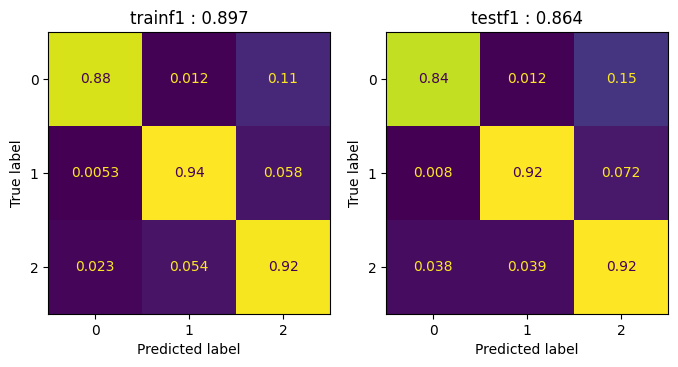

In [15]:
from sage.utils import *
from sklearn.metrics import ConfusionMatrixDisplay
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
loss,y_true,y_pred = evaluate(dataloader=trainloader,model=model,criterion=criterion,device='cuda')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[0],colorbar=False)
axes[0].set_title(f'trainf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=criterion,device='cuda')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[1],colorbar=False)
axes[1].set_title(f'testf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
# train .886 test .858 seq 3
# train .897 test .869 seq 5
# train .906 test .872 seq 9